In [4]:
import os, pathlib
print("CWD:", os.getcwd())
pathlib.Path("data").mkdir(exist_ok=True)

CWD: C:\Proyectos\milk-prices-scraper\notebooks


In [5]:
from pathlib import Path
import pandas as pd
import os

# 1) Mira desde dónde se está ejecutando el notebook
print("CWD:", os.getcwd())

# 2) Intenta la ruta habitual
candidate = Path("data/clal_powders_prices.csv")

# 3) Si no existe, búscalo en TODO el proyecto
if not candidate.exists():
    matches = list(Path(".").rglob("clal_powders_prices.csv"))
    print("Encontrados:", [str(m) for m in matches])
    if matches:
        candidate = matches[0]

# 4) Como última opción: prueba con la ruta absoluta (ajústala si tu carpeta es otra)
if not candidate.exists():
    absolute = Path(r"C:\Proyectos\milk-prices-scraper\data\clal_powders_prices.csv")
    if absolute.exists():
        candidate = absolute

print("Usando CSV:", candidate)

# 5) Si no existe en ningún sitio, falla claramente
if not candidate.exists():
    raise FileNotFoundError(
        "No encuentro clal_powders_prices.csv. Si lo tenías, dime dónde apareció en la búsqueda.\n"
        "Si no existe, vuelve a generar el CSV (indicado abajo en Paso 2)."
    )

df = pd.read_csv(candidate, parse_dates=["date"]).sort_values("date")
df.head()

CWD: C:\Proyectos\milk-prices-scraper\notebooks
Encontrados: []
Usando CSV: C:\Proyectos\milk-prices-scraper\data\clal_powders_prices.csv


,commodity,geography,spec,date,price,unit,source_url
0,WPC,World,WPC – avg (CLAL getgeneric),2020-01-01,2206.29,USD/Tons,https://www.clal.it/en/index.php?section=demi
1,WPC,World,WPC – avg (CLAL getgeneric),2020-02-01,2235.64,USD/Tons,https://www.clal.it/en/index.php?section=demi
2,WPC,World,WPC – avg (CLAL getgeneric),2020-03-01,2237.70,USD/Tons,https://www.clal.it/en/index.php?section=demi
3,WPC,World,WPC – avg (CLAL getgeneric),2020-04-01,2223.92,USD/Tons,https://www.clal.it/en/index.php?section=demi
4,WPC,World,WPC – avg (CLAL getgeneric),2020-05-01,2119.76,USD/Tons,https://www.clal.it/en/index.php?section=demi


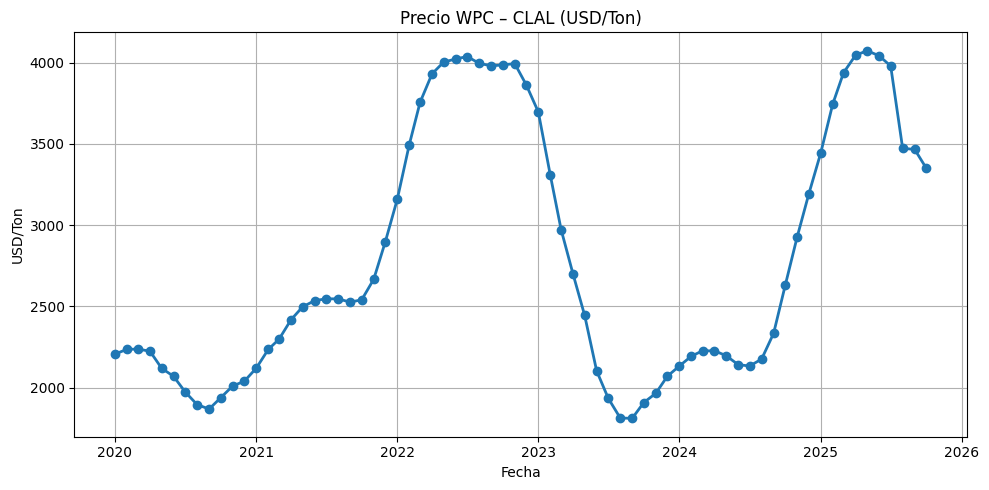

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df["date"], df["price"], marker="o", linewidth=2)
ax.set_title("Precio WPC – CLAL (USD/Ton)")
ax.set_xlabel("Fecha"); ax.set_ylabel("USD/Ton"); ax.grid(True)
fig.tight_layout()
fig.savefig("data/wpc_price_trend.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show(); plt.close(fig)

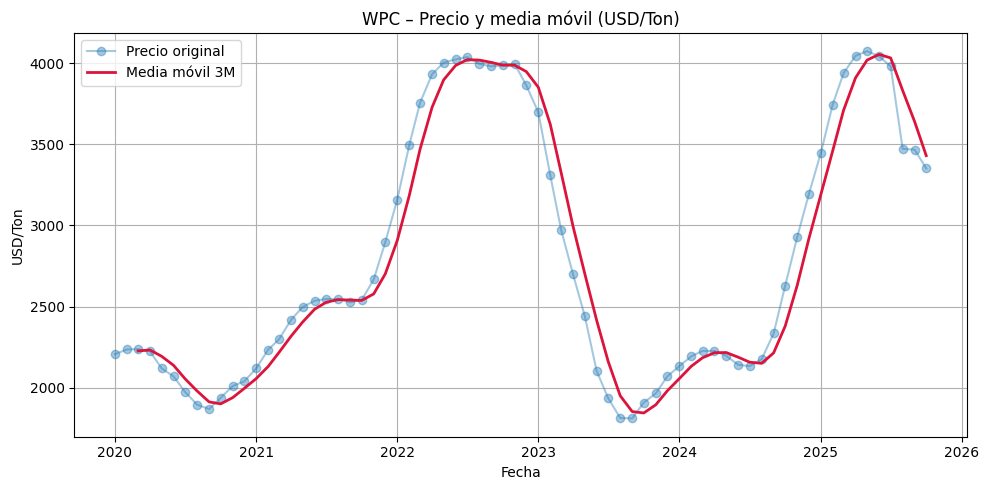

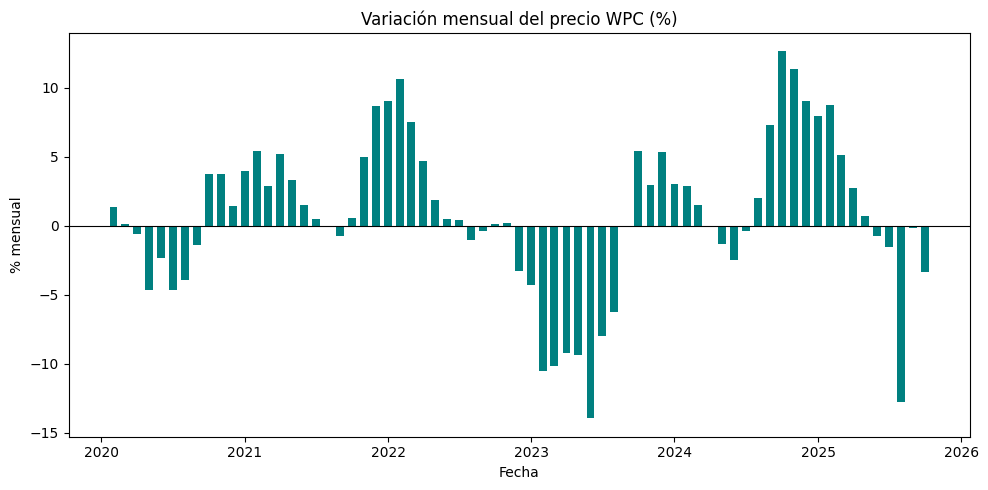

In [7]:
# Calcular media móvil de 3 meses y variación porcentual
df["media_movil_3m"] = df["price"].rolling(window=3).mean()
df["variacion_pct"] = df["price"].pct_change() * 100

# Gráfico de la media móvil
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df["date"], df["price"], marker="o", alpha=0.4, label="Precio original")
ax.plot(df["date"], df["media_movil_3m"], color="crimson", linewidth=2, label="Media móvil 3M")
ax.set_title("WPC – Precio y media móvil (USD/Ton)")
ax.set_xlabel("Fecha"); ax.set_ylabel("USD/Ton")
ax.grid(True); ax.legend()
fig.tight_layout()
fig.savefig("data/wpc_price_moving_avg.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()

# Gráfico de variación porcentual mensual
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(df["date"], df["variacion_pct"], width=20, color="teal")
ax.set_title("Variación mensual del precio WPC (%)")
ax.set_xlabel("Fecha"); ax.set_ylabel("% mensual")
ax.axhline(0, color="black", linewidth=0.8)
fig.tight_layout()
fig.savefig("data/wpc_price_variation.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()